In [1]:
import keras
import keras.models as kmod
import keras.layers as klay
import keras.utils as kutils
import numpy as np
import sklearn.ensemble
import sklearn.model_selection
import sklearn.cluster
import sklearn.preprocessing
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


# Classifying MNIST with Random Features
The MNIST dataset is a common "benchmark" dataset for deep learning tutorials and research, e.g. exploring new network architectures and network elements. However, the dataset itself is unsuitable for this task as it is too trivial. In this notebook, I show that classifying numbers with a deep convolutional neural network (DCNN) is essentially a trivial task. For this, I compare the classification accuracy of a conventionally trained DCNN to the features extracted by an untrained, i.e. randomly initialized, DCNN. This comparison will highlight that training a neural network is unnecessary to accurately differentiate MNIST digits.

## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Transform labels
y_train_cat = kutils.to_categorical(y_train)
y_test_cat = kutils.to_categorical(y_test)

# Transform input to be 4D
x_train = x_train[..., None]
x_test = x_test[..., None]

## Conventional CNN with Training
The network architecture chosen here has no deeper meaning and was chosen for its simplicity.

In [3]:
# create model
model = kmod.Sequential()

# add model layers
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    input_shape=x_train.shape[1:]))
model.add(klay.MaxPool2D())
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform"))
model.add(klay.MaxPool2D())
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform"))
model.add(klay.Flatten())
model.add(klay.Dense(
    units=10, activation='softmax', 
    kernel_initializer="glorot_uniform"))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 22s 367us/step - loss: 0.4391 - acc: 0.9202 - val_loss: 0.0834 - val_acc: 0.9753
Epoch 2/3
60000/60000 [==============================] - 20s 341us/step - loss: 0.0790 - acc: 0.9764 - val_loss: 0.0624 - val_acc: 0.9799
Epoch 3/3
60000/60000 [==============================] - 19s 321us/step - loss: 0.0588 - acc: 0.9823 - val_loss: 0.0613 - val_acc: 0.9812


In [4]:
cnn_acc = model.evaluate(x=x_test, y=y_test_cat)
print("Trained CNN Accuracy = {}%".format(np.round(cnn_acc[1]*100, 2)))

10000/10000 [==============================] - 1s 92us/step
Trained CNN Accuracy = 98.12%


## Extracting Features with Random Network Weights
The last layer of a neural network can typically be considered the classification or regression step with all previous layers aiming to extract complex, non-linear features. If the network above is adjusted so that only the final layer is trainable, we can see how well features extracted by randomly initialized weights separate the MNIST classes. We will loop this to observe the effects of multiple random initializations.

In [11]:
random_feature_accuracies = []

for ii in range(10):
    # create model
    model = kmod.Sequential()

    # add model layers
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        input_shape=x_train.shape[1:], 
        trainable=False))
    model.add(klay.MaxPool2D(trainable=False))
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        kernel_initializer="glorot_uniform", 
        trainable=False))
    model.add(klay.MaxPool2D(trainable=False))
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        kernel_initializer="glorot_uniform", 
        trainable=False))
    model.add(klay.Flatten(trainable=False))
    model.add(klay.Dense(
        units=10, activation='softmax', 
        kernel_initializer="glorot_uniform"))

    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5, verbose=0)
    random_feature_accuracies.append(model.evaluate(x=x_test, y=y_test_cat, verbose=0)[1])

[0.6588]
[0.6588, 0.3774]
[0.6588, 0.3774, 0.7436]
[0.6588, 0.3774, 0.7436, 0.6812]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634, 0.4742]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634, 0.4742, 0.675]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634, 0.4742, 0.675, 0.5733]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634, 0.4742, 0.675, 0.5733, 0.8523]
[0.6588, 0.3774, 0.7436, 0.6812, 0.8634, 0.4742, 0.675, 0.5733, 0.8523, 0.5987]


In [26]:
print("Untrained CNN Accuracy = ({} +/- {})%".format(
    np.round(np.mean(random_feature_accuracies)*100, 2), 
    np.round(np.std(random_feature_accuracies)*100, 2)))

Untrained CNN Accuracy = (64.98 +/- 14.51)%


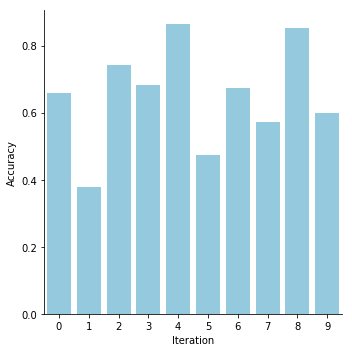

In [27]:
random_feature_accuracies2 = pd.DataFrame({
    "Iteration": range(10), 
    "Accuracy": random_feature_accuracies})

sns.catplot(
    x="Iteration", y="Accuracy", data=random_feature_accuracies2, 
    kind="bar", color="skyblue")

### Alternative Classifiers
We can also leave out the classification step from above entirely and only extract the features computed by the penultimate layer.

In [7]:
# create model
model = kmod.Sequential()

# add model layers
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    input_shape=x_train.shape[1:], 
    trainable=False))
model.add(klay.MaxPool2D(trainable=False))
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform", 
    trainable=False))
model.add(klay.MaxPool2D(trainable=False))
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform", 
    trainable=False))
model.add(klay.Flatten(trainable=False))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_features = model.predict(x_train)
test_features = model.predict(x_test)

#### Principal Component Analysis
A principal component analysis with two components shows that, while the data is not clearly separable, there are definitive trends, e.g. the clear separation of the digits 1, 7, and 9.

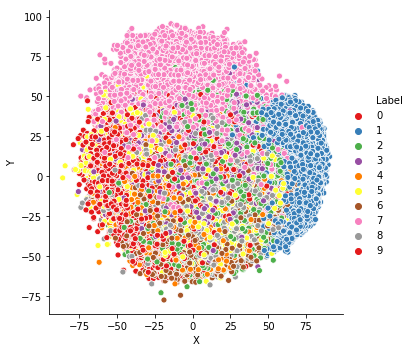

In [8]:
all_features = np.concatenate((train_features, test_features), axis=0)
pca_features = sklearn.decomposition.PCA(n_components=2).fit_transform(X=all_features)
pca_features = pd.DataFrame(pca_features, columns=("X", "Y"))
pca_features["Label"] = np.concatenate((y_train, y_test))
# Turn the 'Label' column into strings to ensure categorical treatment
pca_features["Label"] = pca_features["Label"].astype("str")
sns.relplot(
    data=pca_features, x="X", y="Y", hue="Label", 
    palette=sns.color_palette(palette="Set1", n_colors=10))

#### Training a Classifier on Random-DNN Features
Inputting these features into a classifier paints a much clearer picture. Here, I use a random forest classifier to not have to worry about feature pre-processing. The accuracy is comparable to that of the trained neural network.

In [9]:
# Use random forest to classify "random-weight" features
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X=train_features, y=y_train)
rf_acc = rf.score(X=test_features, y=y_test)
print("Random Forest Accuracy = {}%".format(np.round(rf_acc*100, 2)))

Random Forest Accuracy = 94.7%


## Conclusion
The accuracy of a classifier trained on randomly initialized weights leads to comparable accuracies as a fully trained network when attempting. A simple non-linear classifier, as used in the semi-trained DCNN, shows accuracies notably better than random guessing (~10%) while a non-parametric, random forest classifier trained on the random-weight features will exhibit nearly equivalent accuracy as the fully trained DCNN.

These results indicate that the MNIST dataset is too trivial to serve as benchmark dataset. Any conclusions drawn from this dataset most likely reflect this triviality more than the power of the research matter, e.g. network architectures or novel network elements.